# **Air Quality Prediction**



In [142]:
import warnings
warnings.filterwarnings('ignore')
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Data Ingestion Stage

In [143]:
# API RUL
API_URL = "https://api.aqi.in/api/v1/getIndiaLocations"
response = requests.get(API_URL)
# checking request was successful or not
if response.status_code == 200:
    data1 = response.json()
    print(data1)
else:
    print("Error:", response.status_code) # printing error

{'Locations': [{'stationname': 'F Block,Sirsa,Haryana,India', 'locationId': '11850', 'dev_type': 1, 'lat': '29.5364', 'lon': '75.0158', 'Elevation': '200', 'updated_at': '2024-04-13 16:34:04', 'formatdate': '13 Apr 2024, 04:34pm', 'timeStamp': '1709870400', 'cityName': 'Sirsa', 'stateName': 'Haryana', 'countryName': 'India', 'source': 'World Air Quality Index Project', 'sourceUrl': 'https://waqi.info', 'airComponents': [{'sensorName': 'co', 'sensorData': 1151, 'senDevId': 'co', 'sensorUnit': 'ppb'}, {'sensorName': 'no2', 'sensorData': 4, 'senDevId': 'no2', 'sensorUnit': 'ppb'}, {'sensorName': 'o3', 'sensorData': 47, 'senDevId': 'o3', 'sensorUnit': 'ppb'}, {'sensorName': 'pm10', 'sensorData': 130, 'senDevId': 'pm10', 'sensorUnit': 'ug/m3'}, {'sensorName': 'pm25', 'sensorData': 81, 'senDevId': 'pm25', 'sensorUnit': 'ug/m3'}, {'sensorName': 'so2', 'sensorData': 0, 'senDevId': 'so2', 'sensorUnit': 'ppb'}, {'sensorName': 'AQI-IN', 'sensorData': 169, 'senDevId': 'AQI-IN', 'sensorUnit': 'IN-A

# 2. Data Cleaning Stage

In [144]:
data = pd.json_normalize(data1, 'Locations')


In [145]:
sensor_val = pd.json_normalize(data['airComponents'])
sensor_val.shape
sensor = pd.DataFrame()
for col in sensor_val.columns:
    col_name = sensor_val[col][0]['sensorName'] + "_" + sensor_val[col][0]['sensorUnit']
    sensor[col_name] = sensor_val[col].apply(lambda x: x['sensorData'])




In [146]:
final_data = pd.merge(data, sensor, left_index = True, right_index = True)

# dropping those column that are not needed for the prediction purpose.
final_data.drop(columns = ['stationname', 'locationId','formatdate' ,'dev_type', 'updated_at', 'timeStamp', 'cityName', 'stateName',
       'countryName', 'source', 'sourceUrl', 'airComponents' ], inplace = True)

final_data.columns

Index(['lat', 'lon', 'Elevation', 'co_ppb', 'no2_ppb', 'o3_ppb', 'pm10_ug/m3',
       'pm25_ug/m3', 'so2_ppb', 'AQI-IN_IN-AQI', 'aqi_US-AQI', 't_C', 'p_mb',
       'dew_C', 'h_%', 'w_km/h', 'wd_'],
      dtype='object')

# 3. EDA

In [147]:
final_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 379 entries, 0 to 378
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   lat            379 non-null    object
 1   lon            379 non-null    object
 2   Elevation      355 non-null    object
 3   co_ppb         379 non-null    int64 
 4   no2_ppb        379 non-null    int64 
 5   o3_ppb         379 non-null    int64 
 6   pm10_ug/m3     379 non-null    int64 
 7   pm25_ug/m3     379 non-null    int64 
 8   so2_ppb        379 non-null    int64 
 9   AQI-IN_IN-AQI  379 non-null    int64 
 10  aqi_US-AQI     379 non-null    int64 
 11  t_C            379 non-null    int64 
 12  p_mb           379 non-null    int64 
 13  dew_C          379 non-null    int64 
 14  h_%            379 non-null    int64 
 15  w_km/h         379 non-null    int64 
 16  wd_            379 non-null    int64 
dtypes: int64(14), object(3)
memory usage: 50.5+ KB


**Observation:**
1.  Latitude, longitude and elivation columns are in object format. They need to be changed into numerical column.  

In [148]:
final_data['lon'] = pd.to_numeric(data['lon'])
final_data['lat'] = pd.to_numeric(data['lat'])
final_data['Elevation'] = pd.to_numeric(data['Elevation'])

In [149]:
#Checking for null values
final_data.isna().sum()

lat               0
lon               0
Elevation        24
co_ppb            0
no2_ppb           0
o3_ppb            0
pm10_ug/m3        0
pm25_ug/m3        0
so2_ppb           0
AQI-IN_IN-AQI     0
aqi_US-AQI        0
t_C               0
p_mb              0
dew_C             0
h_%               0
w_km/h            0
wd_               0
dtype: int64

In [150]:
# Filling null values by mean in column Elevation
final_data['Elevation'] = final_data['Elevation'].fillna(final_data['Elevation'].mean())

In [151]:
final_data.describe()

,lat,lon,Elevation,co_ppb,no2_ppb,o3_ppb,pm10_ug/m3,pm25_ug/m3,so2_ppb,AQI-IN_IN-AQI,aqi_US-AQI,t_C,p_mb,dew_C,h_%,w_km/h,wd_
count,379.000000,379.000000,379.000000,379.000000,379.000000,379.000000,379.000000,379.000000,379.000000,379.000000,379.000000,379.000000,379.000000,379.000000,379.000000,379.000000,379.000000
mean,22.624944,78.704557,275.873239,550.857520,13.812665,26.654354,97.986807,42.303430,5.187335,102.044855,110.308707,34.601583,972.306069,14.617414,32.379947,9.817942,197.781003
std,6.150064,4.702963,304.313840,440.164208,13.464209,20.317436,52.407311,27.481216,4.897278,59.183739,41.926456,3.352658,38.420002,5.563849,14.173835,4.832769,65.176456
min,8.514057,72.456691,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,5.000000,7.000000,671.000000,-15.000000,10.000000,1.000000,12.000000
25%,18.478676,76.119186,57.500000,271.000000,4.000000,12.500000,58.000000,23.000000,2.000000,60.500000,76.000000,33.000000,957.000000,10.000000,22.000000,7.000000,159.000000
50%,24.261301,77.400574,211.000000,474.000000,9.000000,21.000000,89.000000,38.000000,4.000000,91.000000,110.000000,35.000000,982.000000,14.000000,30.000000,8.000000,192.000000
75%,28.398842,80.256231,318.500000,672.000000,19.000000,37.000000,130.000000,54.000000,7.000000,125.000000,151.000000,37.000000,999.000000,18.000000,39.000000,12.000000,260.000000
max,34.161190,94.098988,2228.000000,3761.000000,67.000000,109.000000,305.000000,189.000000,47.000000,353.000000,239.000000,40.000000,1008.000000,29.000000,81.000000,22.000000,350.000000


In [152]:
# def air_quality(aqi_value):
#     if aqi_value <= 50:
#         return "Good"
#     elif 51 <= aqi_value <= 100:
#         return "Moderate"
#     elif 101 <= aqi_value <= 200:
#         return "Poor"
#     elif 201 <= aqi_value <= 300:
#         return "Unhealthy"
#     elif 301 <= aqi_value <= 400:
#         return "Very Unhealthy"
#     else:
#         return "Hazardous"

# # Creating a 'Classify_AQI' column, use the air_quality function.
# final_data['Classify_AQI'] = final_data['AQI-IN_IN-AQI'].apply(lambda x: air_quality(x))

# final_data.head(5)

In [153]:
# Observation max value of AQI-IN is 1094 which might be an outliers. Analyzing the same data.
final_data[final_data['AQI-IN_IN-AQI'] > 500]

,lat,lon,Elevation,co_ppb,no2_ppb,o3_ppb,pm10_ug/m3,pm25_ug/m3,so2_ppb,AQI-IN_IN-AQI,aqi_US-AQI,t_C,p_mb,dew_C,h_%,w_km/h,wd_


In [154]:
# It is observed that the data AQI IN is 1094 and AQI-US is 0 which does not make any sense in the data. Thus dropping the data.
final_data.drop(index = final_data[final_data['AQI-IN_IN-AQI'] > 1000].index, inplace = True)

**Univariate analysis**


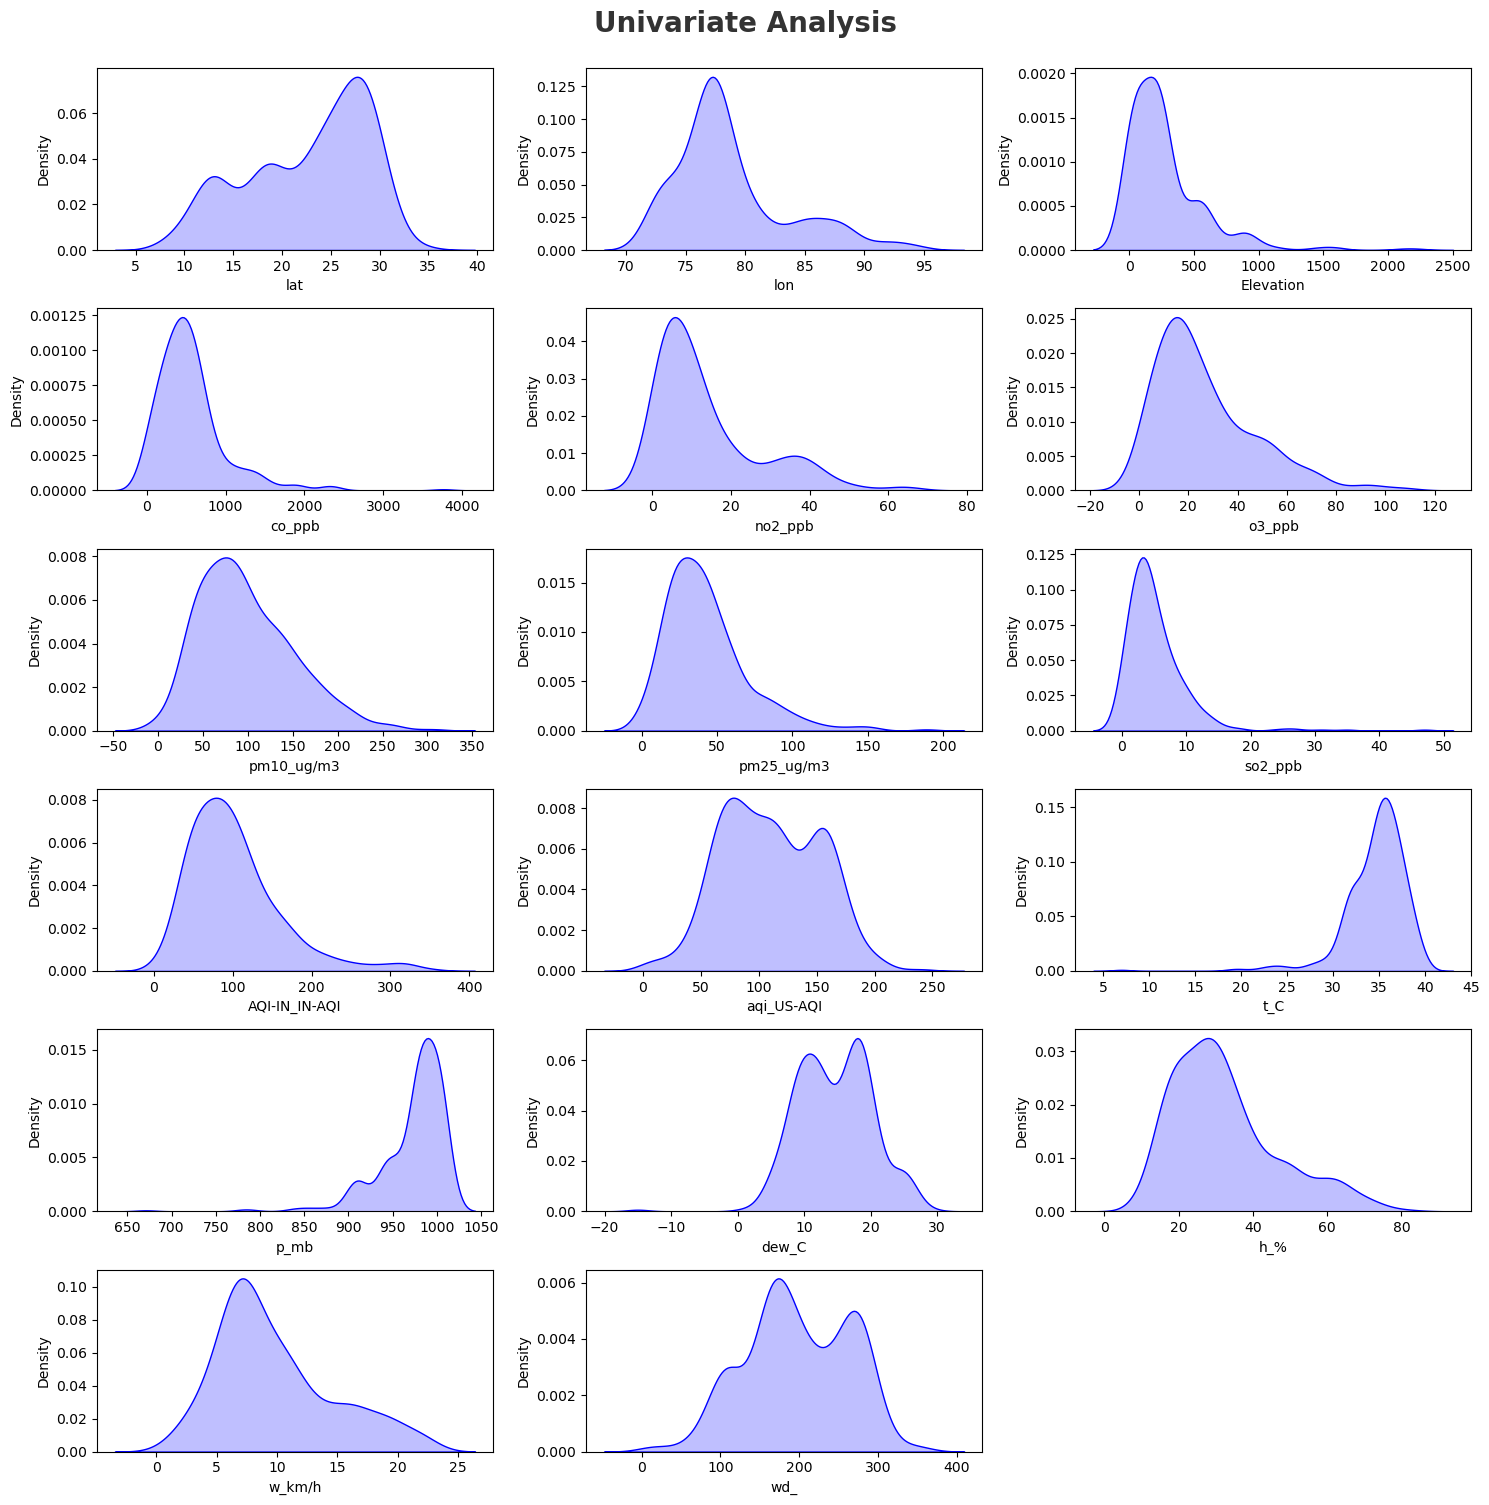

In [155]:
numerical_features = [col for col in final_data.columns if final_data[col].dtypes != 'O']
len(numerical_features)
plt.figure(figsize=(15, 15))
plt.suptitle('Univariate Analysis', fontsize=20, fontweight='bold', alpha=0.8, y=1.)

for i in range(0, len(numerical_features)):
    plt.subplot(6,3 , i+1)
    sns.kdeplot(x=final_data[numerical_features[i]],shade=True, color='b')
    plt.xlabel(numerical_features[i])
    plt.tight_layout()

**Multivariate Analysis**

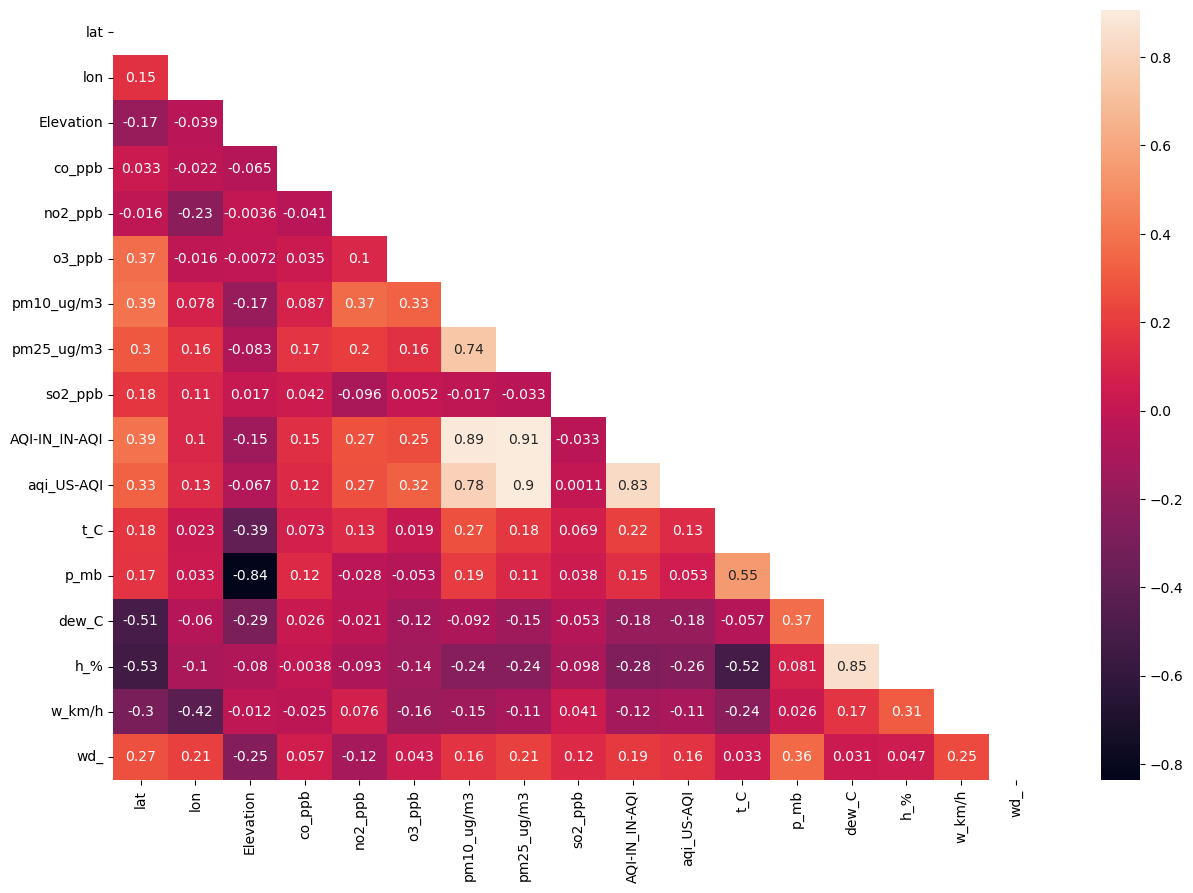

In [156]:
# Select only numeric columns
numeric_columns = final_data.select_dtypes(include=np.number)

# Plot heatmap
plt.figure(figsize=(15, 10))
matrix = np.triu(numeric_columns.corr())
sns.heatmap(numeric_columns.corr(), annot=True, mask=matrix)
plt.yticks(rotation=0)
plt.show()


In [157]:
# import math

# def haversine(lat1, lon1, lat2, lon2, earth_radius=6371.0):
#     """
#     Calculates the great circle distance between two points
#     on the Earth's surface using the Haversine formula.
    
#     :param lat1: Latitude of the first point
#     :param lon1: Longitude of the first point
#     :param lat2: Latitude of the second point
#     :param lon2: Longitude of the second point
#     :param earth_radius: Radius of the Earth (default is in kilometers)
#     :return: Distance between the two points in kilometers
#     """
#     try:
#         # Convert decimal degrees to radians
#         lat1, lon1, lat2, lon2 = map(math.radians, [lat1, lon1, lat2, lon2])

#         # Haversine formula
#         dlat = lat2 - lat1
#         dlon = lon2 - lon1
#         a = math.sin(dlat / 2) ** 2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2) ** 2
#         c = 2 * math.asin(math.sqrt(a))
#         distance = earth_radius * c
#         return distance

#     except Exception as e:
#         raise e

In [158]:
# lat1 = 17.3574  # Latitude of the first point
# lon1 = 78.4767  # Longitude of the first point
# lat2 = 29.5364  # Latitude of the second point
# lon2 = 75.0158  # Longitude of the second point

# # Calculate distance between the two points
# distance_between_points = haversine(lat1, lon1, lat2, lon2)
# print("Distance between the two points:", distance_between_points, "kilometers") 

In [238]:
# User's location
user_lat = float(input("Enter the lat: "))  # User's latitude
user_lon = float(input("Enter the lon: "))  # User's longitude

# Calculate distance for each location in the dataset
final_data['distance'] = final_data.apply(lambda row: haversine(user_lat, user_lon, row['lat'], row['lon']), axis=1)

# Add user's latitude and longitude to the dataset
final_data['user_lat'] = user_lat
final_data['user_lon'] = user_lon 

Enter the lat: 26.9164092
Enter the lon: 75.8016788


In [239]:
# list of radii
radii = [50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 800, 1000]

# Create an empty list to store filtered dataframes
filtered_dataframes = []

# Filter and store data for each radius
for radius in radii:
    # Filter locations within the radius
    nearby_locations = final_data[final_data['distance'] <= radius]
    
    # Check if there are any locations within the radius
    if len(nearby_locations) >= 3:
        # Append the filtered dataframe to the list
        filtered_dataframes.append(nearby_locations)

# Combine the filtered dataframes into one dataframe
filtered_dataframe = pd.concat(filtered_dataframes)

# View the top 5 rows
top_5_filtered = filtered_dataframe.head(5)

In [243]:
# Sort the DataFrame by distance in descending order
sorted_filtered = top_5_filtered.sort_values(by='distance', ascending=True)

# Drop duplicates based on all columns
sorted_filtered = sorted_filtered.drop_duplicates()

# Select the top 3 rows
top_5_distances = sorted_filtered

In [244]:
top_5_distances.head(5) 

,lat,lon,Elevation,co_ppb,no2_ppb,o3_ppb,pm10_ug/m3,pm25_ug/m3,so2_ppb,AQI-IN_IN-AQI,aqi_US-AQI,t_C,p_mb,dew_C,h_%,w_km/h,wd_,distance,user_lat,user_lon
162,26.916409,75.801679,436.0,852,41,48,116,44,6,111,122,36,957,14,26,12,189,0.000000,26.916409,75.801679
172,26.940517,75.800702,464.0,700,42,42,122,67,5,125,157,36,955,14,26,8,187,2.682371,26.916409,75.801679
5,26.900596,75.825279,452.0,260,19,26,85,47,8,85,129,36,956,13,25,13,187,2.927072,26.916409,75.801679


In [245]:
# Calculate the average of each column in the top_5_filtered DataFrame
average_values = top_5_filtered.mean()

# Print the average values
print("Average values:")
print(average_values)

Average values:
lat               26.914905
lon               75.810923
Elevation        448.000000
co_ppb           584.800000
no2_ppb           32.400000
o3_ppb            38.000000
pm10_ug/m3       104.800000
pm25_ug/m3        49.800000
so2_ppb            6.600000
AQI-IN_IN-AQI    103.400000
aqi_US-AQI       131.800000
t_C               36.000000
p_mb             956.200000
dew_C             13.600000
h_%               25.600000
w_km/h            11.600000
wd_              187.800000
distance           1.707303
user_lat          26.916409
user_lon          75.801679
dtype: float64


In [206]:
top_5_distances.to_csv("top_5_distances.csv")

# 4. Model Training

In [26]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, Ridge,Lasso
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
# from catboost import CatBoostRegressor
from xgboost import XGBRegressor
import warnings
warnings.filterwarnings('ignore')

In [17]:
# final_data = final_data.sample(frac = 1)
# final_data

In [18]:
# final_data = final_data.reset_index()
# final_data = final_data.drop(columns=['index'])
final_data

,lat,lon,Elevation,co_ppb,no2_ppb,o3_ppb,pm10_ug/m3,pm25_ug/m3,so2_ppb,AQI-IN_IN-AQI,aqi_US-AQI,t_C,p_mb,dew_C,h_%,w_km/h,wd_
0,29.536400,75.015800,200.000000,437,4,31,115,74,21,146,161,29,987,7,25,6,146
1,30.233011,74.907758,207.000000,23,11,26,99,60,11,100,153,29,987,9,29,4,130
2,31.619980,74.876485,233.000000,169,7,29,65,39,6,65,110,26,984,15,49,6,109
3,23.520444,87.311923,109.000000,883,35,13,125,48,11,116,132,28,998,16,49,17,242
4,26.144500,91.736200,50.000000,574,4,10,184,160,13,331,210,31,1004,21,57,3,303
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
374,12.969219,77.608279,275.873239,198,37,12,110,51,2,106,139,29,911,15,42,10,241
375,12.920504,77.609694,275.873239,529,30,20,88,43,3,88,119,29,912,18,50,8,242
376,27.310130,88.596870,275.873239,322,14,55,81,36,1,81,102,21,873,13,60,2,184
377,28.423252,77.067220,275.873239,1450,29,30,382,275,1,419,325,30,984,7,24,3,204


**LabelEncoding**

In [27]:
from sklearn.preprocessing import LabelEncoder
enc = LabelEncoder()

In [20]:
# final_data['Classify_AQI'] = enc.fit_transform(final_data['Classify_AQI'])

In [21]:
y = final_data['AQI-IN_IN-AQI']

In [22]:
y

0      146
1      100
2       65
3      116
4      331
      ... 
374    106
375     88
376     81
377    419
378    146
Name: AQI-IN_IN-AQI, Length: 379, dtype: int64

In [23]:
# X = final_data.drop(columns = ['Classify_AQI', 'AQI-IN_IN-AQI', 'aqi_US-AQI', ])  # Selecting only 'lat' and 'lon'
X = final_data.drop(columns = [ 'AQI-IN_IN-AQI', 'aqi_US-AQI', ])  # Selecting only 'lat' and 'lon'

In [24]:
X

,lat,lon,Elevation,co_ppb,no2_ppb,o3_ppb,pm10_ug/m3,pm25_ug/m3,so2_ppb,t_C,p_mb,dew_C,h_%,w_km/h,wd_
0,29.536400,75.015800,200.000000,437,4,31,115,74,21,29,987,7,25,6,146
1,30.233011,74.907758,207.000000,23,11,26,99,60,11,29,987,9,29,4,130
2,31.619980,74.876485,233.000000,169,7,29,65,39,6,26,984,15,49,6,109
3,23.520444,87.311923,109.000000,883,35,13,125,48,11,28,998,16,49,17,242
4,26.144500,91.736200,50.000000,574,4,10,184,160,13,31,1004,21,57,3,303
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
374,12.969219,77.608279,275.873239,198,37,12,110,51,2,29,911,15,42,10,241
375,12.920504,77.609694,275.873239,529,30,20,88,43,3,29,912,18,50,8,242
376,27.310130,88.596870,275.873239,322,14,55,81,36,1,21,873,13,60,2,184
377,28.423252,77.067220,275.873239,1450,29,30,382,275,1,30,984,7,24,3,204


**Preparing X and Y variables**

In [25]:
# separate dataset into train and test

X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=42,test_size=0.3)

In [28]:
# Create Column Transformer with 3 types of transformers
num_features = X.select_dtypes(exclude="object").columns
cat_features = X.select_dtypes(include="object").columns

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

numeric_transformer = StandardScaler()
oh_transformer = OneHotEncoder()

preprocessor = ColumnTransformer(
    [
        ("OneHotEncoder", oh_transformer, cat_features),
         ("StandardScaler", numeric_transformer, num_features),
    ]
)

In [27]:
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)


In [28]:
X_train.shape
y_train.shape

(265,)

In [29]:
# # Split the data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# X_train.shape, X_test.shape

**Create an Evaluate Function to give all metrics after model Training**

In [30]:
def evaluate_model(true, predicted):
    mae = mean_absolute_error(true, predicted)
    mse = mean_squared_error(true, predicted)
    rmse = np.sqrt(mean_squared_error(true, predicted))
    r2_square = r2_score(true, predicted)
    return mae, rmse, r2_square

In [31]:
# models = {

#     "Lasso": Lasso(),
#     "Ridge": Ridge(),
#     "K-Neighbors Regressor": KNeighborsRegressor(),
#     "Decision Tree": DecisionTreeRegressor(),
#     "Random Forest Regressor": RandomForestRegressor(),
#     "XGBRegressor": XGBRegressor(),

# }
# model_list = []
# r2_list =[]

# for i in range(len(list(models))):
#     model = list(models.values())[i]
#     model.fit(X_train, y_train) # Train model

#     # Make predictions
#     y_train_pred = model.predict(X_train)
#     y_test_pred = model.predict(X_test)

#     # Evaluate Train and Test dataset
#     model_train_mae , model_train_rmse, model_train_r2 = evaluate_model(y_train, y_train_pred)

#     model_test_mae , model_test_rmse, model_test_r2 = evaluate_model(y_test, y_test_pred)


#     print(list(models.keys())[i])
#     model_list.append(list(models.keys())[i])

#     print('Model performance for Training set')
#     print("- Root Mean Squared Error: {:.4f}".format(model_train_rmse))
#     print("- Mean Absolute Error: {:.4f}".format(model_train_mae))
#     print("- R2 Score: {:.4f}".format(model_train_r2))

#     print('----------------------------------')

#     print('Model performance for Test set')
#     print("- Root Mean Squared Error: {:.4f}".format(model_test_rmse))
#     print("- Mean Absolute Error: {:.4f}".format(model_test_mae))
#     print("- R2 Score: {:.4f}".format(model_test_r2))

#     print('='*35)
#     print('\n')

In [32]:
models = {
    "Lasso": Lasso(),
    "Ridge": Ridge(),
    "K-Neighbors Regressor": KNeighborsRegressor(),
    "Decision Tree": DecisionTreeRegressor(),
    "Random Forest Regressor": RandomForestRegressor(),
    "XGBRegressor": XGBRegressor()
}

model_list = []
r2_list = []

# hyperparameters for each model
param_grid = {
    "Lasso": {'alpha': [0.1, 0.5, 1.0]},
    "Ridge": {'alpha': [0.1, 0.5, 1.0]},
    "K-Neighbors Regressor": {'n_neighbors': [3, 5, 7]},
    "Decision Tree": {'max_depth': [3, 5, 7]},
    "Random Forest Regressor": {'n_estimators': [100, 200, 300], 'max_depth': [5, 10, 15]},
    "XGBRegressor": {'n_estimators': [100, 200, 300], 'max_depth': [3, 5, 7]}
}

best_models = {}

for model_name, model in models.items():
    random_search = RandomizedSearchCV(estimator=model, param_distributions=param_grid[model_name], n_iter=5, cv=3, scoring='r2', verbose=2, random_state=42)

    random_search.fit(X_train, y_train)

    best_model = random_search.best_estimator_
    best_models[model_name] = best_model

    y_train_pred = best_model.predict(X_train)
    y_test_pred = best_model.predict(X_test)

    model_train_mae , model_train_rmse, model_train_r2 = evaluate_model(y_train, y_train_pred)
    model_test_mae , model_test_rmse, model_test_r2 = evaluate_model(y_test, y_test_pred)

    model_list.append(model_name)
    r2_list.append(model_test_r2)

    print(model_name)
    print('Model performance for Training set')
    print("- Root Mean Squared Error: {:.4f}".format(model_train_rmse))
    print("- Mean Absolute Error: {:.4f}".format(model_train_mae))
    print("- R2 Score: {:.4f}".format(model_train_r2))
    print('----------------------------------')
    print('Model performance for Test set')
    print("- Root Mean Squared Error: {:.4f}".format(model_test_rmse))
    print("- Mean Absolute Error: {:.4f}".format(model_test_mae))
    print("- R2 Score: {:.4f}".format(model_test_r2))
    print('='*35)
    print('\n')

best_models

Fitting 3 folds for each of 3 candidates, totalling 9 fits
[CV] END ..........................................alpha=0.1; total time=   0.0s
[CV] END ..........................................alpha=0.1; total time=   0.0s
[CV] END ..........................................alpha=0.1; total time=   0.0s
[CV] END ..........................................alpha=0.5; total time=   0.0s
[CV] END ..........................................alpha=0.5; total time=   0.0s
[CV] END ..........................................alpha=0.5; total time=   0.0s
[CV] END ..........................................alpha=1.0; total time=   0.0s
[CV] END ..........................................alpha=1.0; total time=   0.0s
[CV] END ..........................................alpha=1.0; total time=   0.0s
Lasso
Model performance for Training set
- Root Mean Squared Error: 20.5356
- Mean Absolute Error: 11.9972
- R2 Score: 0.9697
----------------------------------
Model performance for Test set
- Root Mean Squared 

{'Lasso': Lasso(),
 'Ridge': Ridge(),
 'K-Neighbors Regressor': KNeighborsRegressor(n_neighbors=3),
 'Decision Tree': DecisionTreeRegressor(max_depth=5),
 'Random Forest Regressor': RandomForestRegressor(max_depth=5),
 'XGBRegressor': XGBRegressor(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)}

**Results**

In [33]:
pd.DataFrame(list(zip(model_list, r2_list)), columns=['Model Name', 'R2_Score']).sort_values(by=["R2_Score"],ascending=False)


,Model Name,R2_Score
5,XGBRegressor,0.973962
0,Lasso,0.948624
1,Ridge,0.944529
4,Random Forest Regressor,0.926467
3,Decision Tree,0.883132
2,K-Neighbors Regressor,0.753756


In [34]:
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (265, 15)
X_test shape: (114, 15)
y_train shape: (265,)
y_test shape: (114,)


**Linear Regression**

In [35]:
lin_model = LinearRegression(fit_intercept=True)
lin_model = lin_model.fit(X_train, y_train)
y_pred = lin_model.predict(X_test)
score = r2_score(y_test, y_pred)*100
print(" Accuracy of the model is %.2f" %score)

 Accuracy of the model is 94.55


**Decision Tree**

In [36]:
dt_model = DecisionTreeRegressor()
dt_model = dt_model.fit(X_train, y_train)
y_pred = dt_model.predict(X_test)
score = r2_score(y_test, y_pred)*100
print(" Accuracy of the model is %.2f" %score)

 Accuracy of the model is 85.06


**Random Forest**

In [37]:
rf_model = RandomForestRegressor()
rf_model = rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)
score = r2_score(y_test, y_pred)*100
print(" Accuracy of the model is %.2f" %score)

 Accuracy of the model is 93.35


**XGB Boost Model**

In [38]:
XGB_model = XGBRegressor(fit_intercept=True)
XGB_model = XGB_model.fit(X_train, y_train)
y_pred = XGB_model.predict(X_test)
score = r2_score(y_test, y_pred)*100
print(" Accuracy of the model is %.2f" %score)

 Accuracy of the model is 97.46


**Plot y_pred and y_test**

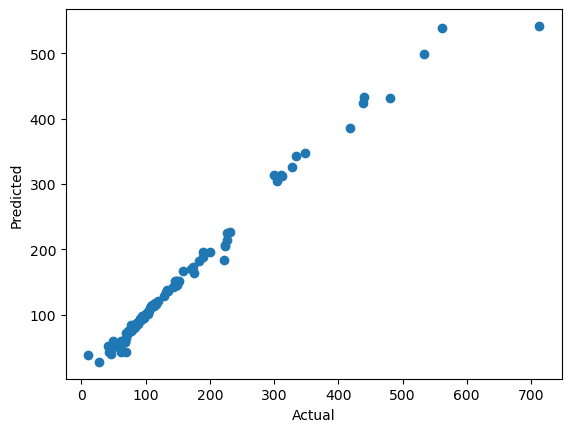

In [39]:
plt.scatter(y_test, y_pred);
plt.xlabel('Actual');
plt.ylabel('Predicted')

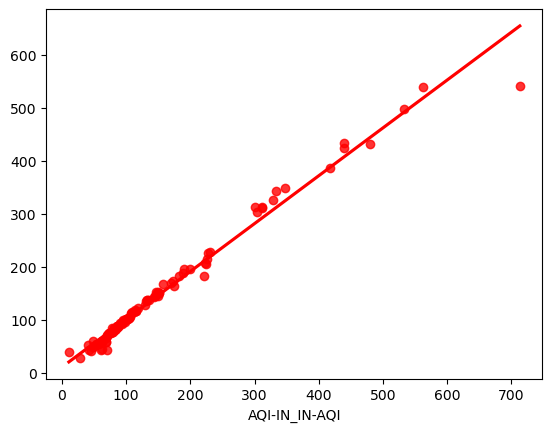

In [40]:
sns.regplot(x=y_test,y=y_pred,ci=None,color ='red');